## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from itertools import product

In [2]:
#load data
customers = pd.read_csv('data_imgs/twm_customer.csv', sep=";")
customers.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [3]:
#don't want noise: cust id, first or last name, street number or number, or postal code
customers_df = customers.drop(['cust_id', 'first_name','last_name', 'street_nbr', 'street_name', 'postal_code'], axis=1)

#Let's check for missing data in percentage
missing_data = pd.DataFrame(customers_df.isnull().sum() / len(customers_df), 
             columns=['percent_null']).sort_values('percent_null',ascending=False)
missing_data

,percent_null
income,0.0
age,0.0
years_with_bank,0.0
nbr_children,0.0
gender,0.0
marital_status,0.0
name_prefix,0.0
city_name,0.0
state_code,0.0


## Categorical features

In [4]:
#each feature's datatypes
customers_df.dtypes

income              int64
age                 int64
years_with_bank     int64
nbr_children        int64
gender             object
marital_status      int64
name_prefix        object
city_name          object
state_code         object
dtype: object

In [5]:
#save index of categorical features
cat_features = customers_df.dtypes[customers_df.dtypes == object].index

#loop through and strip by Series
for i in cat_features:
    customers_df[i] = customers_df[i].str.strip()

In [6]:
#check what are possible values of each to decide numerical translation
print(customers_df.gender.unique()) #gender can become T/F binary
print(customers_df.name_prefix.unique()) #T/F based on is or isnt Doctor
print(customers_df.city_name.unique()) #find numeric info on home city
print(customers_df.state_code.unique()) #Regions (4 values) -> dummy

['M' 'F']
['' 'Mr.' 'Ms.' 'Mrs.' 'Dr.' 'Miss']
['Las Vegas' 'Los Angeles' 'New York City' 'Chicago' 'Honolulu'
 'Washington' 'Houston' 'San Francisco' 'Philadelphia' 'Portland'
 'Riverside' 'Toledo' 'Seattle' 'Sacramento' 'Newark' 'Indianapolis'
 'Rochester' 'Denver' 'Milwaukee' 'Detroit' 'Omaha' 'Tucson' 'Cleveland'
 'San Jose' 'Minneapolis' 'Memphis' 'Long Beach' 'Norfolk' 'Austin'
 'Pittsburgh' 'San Diego' 'Miami' 'Nashville' 'Oakland' 'St Paul'
 'Anaheim' 'Baltimore' 'Corpus Christi' 'St Louis' 'Phoenix' 'New Orleans'
 'El Paso' 'Lexington' 'Kansas City' 'Oklahoma City' 'Tulsa' 'Louisville'
 'Dallas' 'Cincinnati' 'Virginia Beach' 'Dayton' 'Fresno' 'San Antonio'
 'Columbus' 'Santa Ana' 'Boston' 'Mesa' 'Jacksonville' 'Fort Worth'
 'Atlanta' 'Wichita' 'Tampa' 'Charlotte' 'Albuquerque' 'Jersey City'
 'Birmingham' 'Colorado Springs' 'Arlington' 'Buffalo']
['NV' 'CA' 'NY' 'IL' 'HI' 'DC' 'TX' 'PA' 'OR' 'OH' 'WA' 'NJ' 'IN' 'CO'
 'WI' 'MI' 'NB' 'AZ' 'MN' 'TN' 'VA' 'FL' 'MD' 'MO' 'LA' 'KY' '

In [7]:
#replace M/F with 0/1 for T/F data
customers_df = customers_df.replace({'gender': 
                                               {'M': 0,'F': 1}})

#similar for Dr/NotDr
customers_df = customers_df.replace({'name_prefix': 
                      {'Mr.': 0, 'Ms.': 0, 'Mrs.':0, 'Miss':0, 'Dr.':1, '': 0}})

#check
print(customers_df.gender.unique())
print(customers_df.name_prefix.unique())

[0 1]
[0 1]


#### City data

I used the US city data found [here](https://simplemaps.com/data/us-cities).
It is cleaned and sorted in the `w4/cities_cleaning` folder using the below `cities_int` dataframe. 

I used the region csv found [here](https://github.com/cphalpert/census-regions).

In [8]:
#First make a create cities of interest frame
cities_int = customers_df.value_counts(['city_name','state_code']).reset_index().drop(0, axis=1)

#export
cities_int.to_csv('data_imgs/cities_int.csv')

In [9]:
#import clean city data
uscities_df = pd.read_csv('data_imgs/uscities_clean.csv')

uscities_df.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,timezone,ranking
0,New York City,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,America/New_York,1
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,America/Los_Angeles,1
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574,America/Chicago,1
3,Houston,Houston,TX,Texas,48201,Harris,29.7863,-95.3889,5464251,1399,America/Chicago,1
4,San Francisco,San Francisco,CA,California,6075,San Francisco,37.7562,-122.4430,3592294,7256,America/Los_Angeles,1


In [10]:
customers_df['city_pop'] = 0
customers_df['city_density'] = 0

#iterate through each city name and pop and density
for i,j,k in uscities_df[['city','population','density']].itertuples(index=False):
    #generate index of rows matching current city name
    index = customers_df.loc[customers_df['city_name'] == i].index
    #for each row in the index add the relevent population and density data
    customers_df.loc[index, ['city_pop', 'city_density']] = j, k
     
#works!
customers_df.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,city_name,state_code,city_pop,city_density
0,26150,46,5,1,0,2,0,Las Vegas,NV,2104198,1773
1,6605,71,1,0,0,2,0,Los Angeles,CA,12750807,3276
2,18548,38,8,0,1,1,0,Los Angeles,CA,12750807,3276
3,47668,54,3,0,1,1,0,Los Angeles,CA,12750807,3276
4,44554,59,9,2,1,4,0,New York City,NY,18713220,10715


In [11]:
#import region data
usregions = pd.read_csv('data_imgs/us_regions.csv')

usregions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [12]:
#empty column
customers_df['region'] = None

#iterate through each city name and pop and density
for i,j in usregions[['State Code', 'Region']].itertuples(index=False):
    #for each row with index city name = i, set region column value to j
    customers_df.loc[customers_df['state_code'] == i, 'region'] = j
    #print(customers_df.loc[customers_df['state_code'] == i,'region'])
    
customers_df['region'].head()

0         West
1         West
2         West
3         West
4    Northeast
Name: region, dtype: object

In [13]:
#generate dummy from the region data - if they are all false it is Midwest
region_dummy = pd.get_dummies(customers_df['region'], drop_first=True)
#add dummy columns back
#customers_df = pd.concat([customers_df, region_dummy], axis =1)

## Numerical features
Using numeric data to get sum stats

In [14]:
#get rid of last unneeded str columns and save as numeric df
customers_numeric = customers_df.drop(['city_name', 'state_code', 'region'], axis = 1)
#rename doctor column
customers_numeric = customers_numeric.rename(columns={'name_prefix': 'doctorate'})

#check it's all numeric
customers_numeric.dtypes

income             int64
age                int64
years_with_bank    int64
nbr_children       int64
gender             int64
marital_status     int64
doctorate          int64
city_pop           int64
city_density       int64
dtype: object

In [15]:
#just take original continual num columns since we know status of the cat ones we created
num_columns = ['income','age','years_with_bank','nbr_children']

#income, age and yr with bank have 0 as min
for i in num_columns:
    print(f"Statistics for {i} are \n{customers_numeric[i].describe()}")

Statistics for income are 
count       747.000000
mean      22728.281124
std       22207.221405
min           0.000000
25%        7118.500000
50%       17242.000000
75%       31338.000000
max      144157.000000
Name: income, dtype: float64
Statistics for age are 
count    747.000000
mean      42.479250
std       19.114879
min       13.000000
25%       28.000000
50%       42.000000
75%       56.000000
max       89.000000
Name: age, dtype: float64
Statistics for years_with_bank are 
count    747.000000
mean       3.907631
std        2.675634
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max        9.000000
Name: years_with_bank, dtype: float64
Statistics for nbr_children are 
count    747.000000
mean       0.714859
std        1.103410
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: nbr_children, dtype: float64


In [16]:
#these are actually relevent zeros since it has to do with starter bank accounts
customers_numeric.loc[customers_numeric['income'] == 0].head()

,income,age,years_with_bank,nbr_children,gender,marital_status,doctorate,city_pop,city_density
6,0,16,1,0,0,1,0,12750807,3276
11,0,15,0,0,0,1,0,5464251,1399
15,0,15,0,0,0,1,0,2074775,1894
17,0,17,2,0,0,1,0,482111,1308
36,0,15,7,0,0,1,0,2074775,1894


In [17]:
#what's not usual is age of 15 and years_with_bank over 7, so let's fix that
wierd_teens = customers_numeric.loc[(customers_numeric['age'] <= 15) & (customers_numeric['years_with_bank'] > 5)]
#make sure it is unusual
print(len(wierd_teens)/customers.shape[0]) #represents 4.4% of data so think that's good

#remove
customers_numeric = customers_numeric.drop(wierd_teens.index)
#make sure they're gone
len(customers_numeric.loc[(customers_numeric['age'] <= 15) & (customers_numeric['years_with_bank'] > 5)])

0.04417670682730924


0

In [18]:
#no income at a high age would also be strange
len(customers_numeric.loc[(customers['age'] > 20) & 
                          (customers_numeric['income'] == 0)]) #none present

0

## Scale

Scale data but keep distribution


In [19]:
print(customers_numeric.values)

[[   26150       46        5 ...        0  2104198     1773]
 [    6605       71        1 ...        0 12750807     3276]
 [   18548       38        8 ...        0 12750807     3276]
 ...
 [   61300       50        0 ...        0   761195     1155]
 [   15100       37        7 ...        0   739573      553]
 [   17875       18        3 ...        0 12750807     3276]]


In [20]:
#Scaling the data
scaler = StandardScaler()
#fit scaler to data
scaler.fit(customers_numeric.values)

#transform and save into new dataframe
customers_normal = pd.DataFrame(scaler.transform(customers_numeric.values), 
                                columns = customers_numeric.columns)
    
customers_normal.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,doctorate,city_pop,city_density
0,0.107091,0.120215,0.454691,0.225723,-1.125463,0.086460,-0.178303,-0.657055,-0.586866
1,-0.775606,1.468102,-1.043115,-0.669646,-1.125463,0.086460,-0.178303,1.050840,-0.115263
2,-0.236233,-0.311109,1.578046,-0.669646,0.888523,-1.035942,-0.178303,1.050840,-0.115263
3,1.078893,0.551539,-0.294212,-0.669646,0.888523,-1.035942,-0.178303,1.050840,-0.115263
4,0.938258,0.821116,1.952498,1.121093,0.888523,2.331263,-0.178303,2.007311,2.218908


## Data Visualization

With numeric data I can create scatter plots to compare different sets of variables

In [21]:
#get rid of last unneeded str columns and save as numeric df
customers_numeric = customers_df.drop(['city_name', 'state_code', 'region'], axis = 1)
#rename doctor column
customers_numeric = customers_numeric.rename(columns={'name_prefix': 'doctorate'})

#check it's all numeric
customers_numeric.dtypes

income             int64
age                int64
years_with_bank    int64
nbr_children       int64
gender             int64
marital_status     int64
doctorate          int64
city_pop           int64
city_density       int64
dtype: object

In [22]:
#create every possible column combination
combos = list(product(customers_numeric.columns, customers_numeric.columns))
len(combos)

81

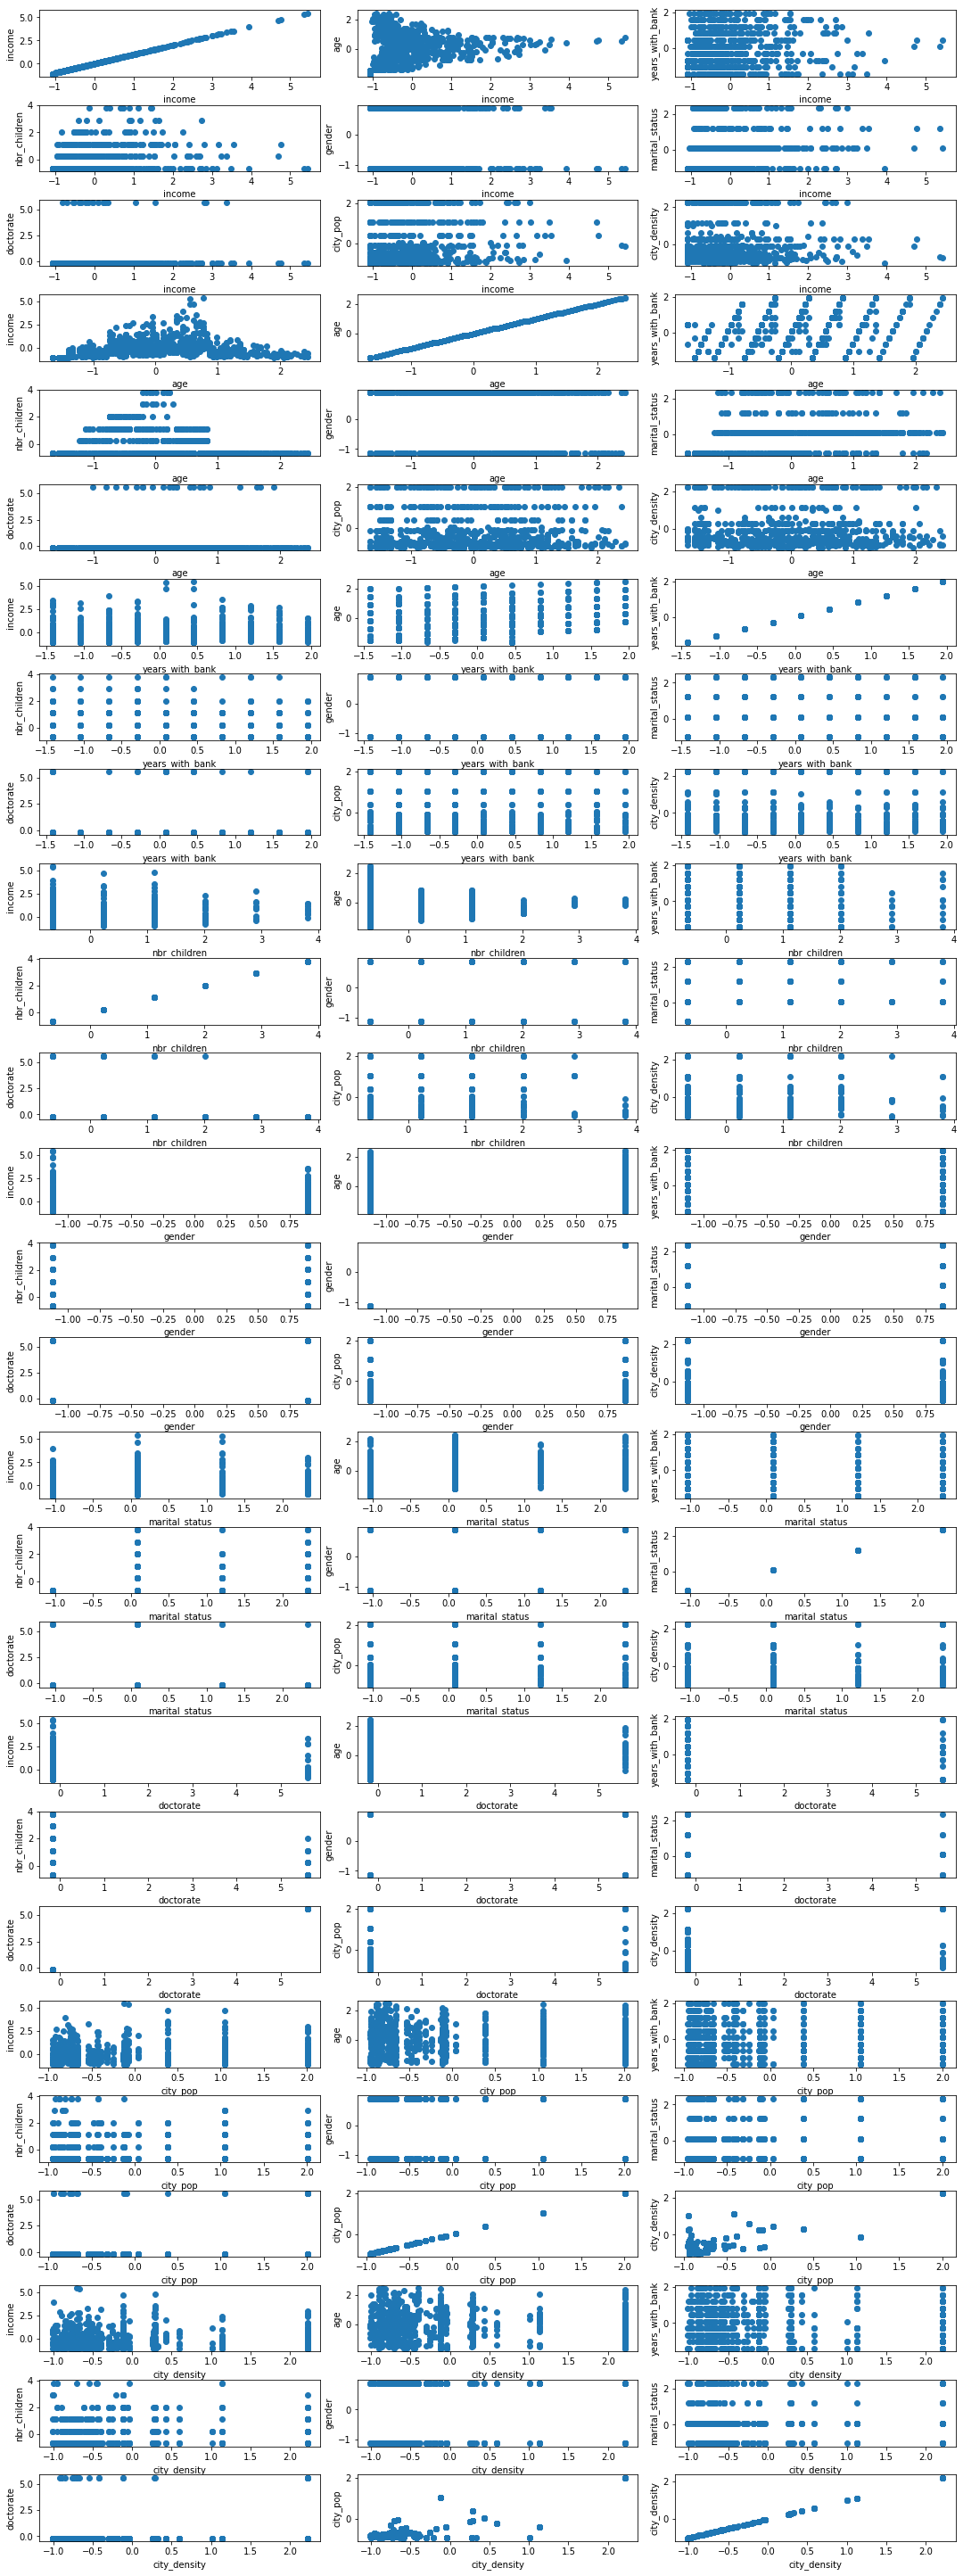

In [23]:
#number of axes = number of possible combos
fig, axes = plt.subplots(27, 3, figsize = (15, 40))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    
    #index of columns
    column1 = combos[i][0]
    column2 = combos[i][1]
    
    # scatter current combination
    ax.scatter(customers_normal[column1], customers_normal[column2])
    ax.set_xlabel(column1)
    ax.set_ylabel(column2)

- city pop and density are corelatted, can just take 1
- age and nbr children are also a correlate, just take age
- age and yrs with bank are also correlate, just take age

In [24]:
#ive ended up removing city density too because the clustering just did not work well with it
customers_normal = customers_normal.drop(['city_density','city_pop', 'doctorate', 'nbr_children', 'years_with_bank'], axis = 1)

In [25]:
#export
customers_normal.to_csv('data_imgs/customers_normal.csv', index=False)